In [1]:
import sys
import sklearn

import tensorflow as tf
from tensorflow import keras
assert tf.__version__>='2.0'

import numpy as np
import os
from pathlib import Path

from tensorflow.keras.utils import plot_model

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("axes",labelsize=14)
mpl.rc("xtick",labelsize=12)
mpl.rc("ytick",labelsize=12)

In [2]:
def generate_time_series(batch_size,n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4,batch_size,1)
  time = np.linspace(0,1,n_steps)
  series = 0.5*np.sin((time-offsets1)*(freq1*10+10))
  series+=0.2*np.sin((time-offsets2)*(freq2*20+20))
  series+=0.1*(np.random.rand(batch_size,n_steps)-0.5)
  return series[...,np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000,n_steps+1)
X_train,y_train = series[:7000,:n_steps],series[:7000,-1]
X_valid,y_valid = series[7000:9000,:n_steps],series[7000:9000,-1]
X_test,y_test = series[9000:,:n_steps], series[9000:,-1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [5]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [6]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

In [7]:
def plot_series(series,y=None,y_pred=None,x_label="$t$",y_label="$x(t)$"):
  n_steps = series.shape[0]
  plt.plot(series,".-", label='x')
  if y is not None:
    plt.plot(n_steps,y,"bx",label="actual y", markersize=10)
  if y_pred is not None:
    plt.plot(n_steps,y_pred,"ro",label="predicted y")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label,fontsize=16)
  if y_label:
    plt.ylabel(y_label,fontsize=16,rotation=0)
  plt.hlines(0,0,100,linewidth=1)
  plt.axis([0,n_steps+1,None,None])
  plt.legend()

In [8]:
def plot_multiple_forecasts(X,Y,Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0,:,0])
  plt.plot(np.arange(n_steps,n_steps+ahead),Y[0,:,0],"bx-",label="Actual")
  plt.plot(np.arange(n_steps,n_steps+ahead),Y_pred[0,:,0],"ro-",label="Forecast",markersize=10)
  plt.axis([0,n_steps+ahead,None,None])
  plt.legend(fontsize=14)

In [9]:
def plot_learning_curves(loss,val_loss):
  plt.plot(np.arange(len(loss))+0.5,loss,"b.-",label="Training loss")
  plt.plot(np.arange(len(val_loss))+1,val_loss,"r.-",label="Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1,20,None,None])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

simple_rnn = keras.models.Sequential([
                                      keras.layers.SimpleRNN(1,input_shape=[None,1])
])
simple_rnn.compile(loss="mse",optimizer="adam")
history = simple_rnn.fit(X_train,y_train,epochs=20,
                         validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 10s 30ms/step - loss: 0.2033 - val_loss: 0.1331
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.1000 - val_loss: 0.0863
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0747 - val_loss: 0.0694
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0612 - val_loss: 0.0575
Epoch 5/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0516 - val_loss: 0.0489
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0445 - val_loss: 0.0424
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0391 - val_loss: 0.0374
Epoch 8/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0349 - val_loss: 0.0333
Epoch 9/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0314 - val_loss: 0.0301
Epoch 10/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0286 - val_l

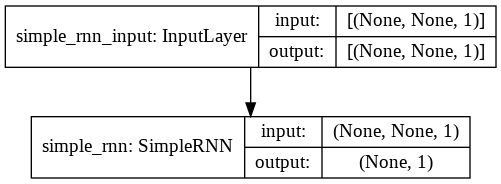

In [11]:
plot_model(simple_rnn,to_file="model_shapes.png",show_shapes=True)

In [12]:
simple_rnn.evaluate(X_valid,y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0141


0.014119226485490799

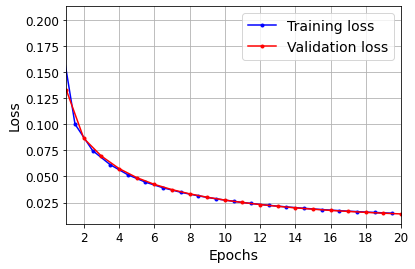

In [13]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

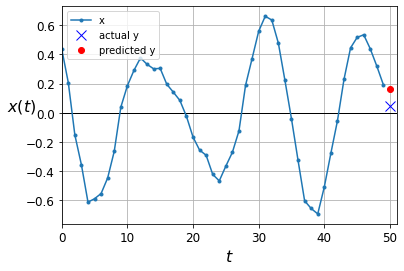

In [14]:
y_pred=simple_rnn.predict(X_test)
plot_series(X_test[0,:,0],y_test[0,:],y_pred[0,:])
plt.show()

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

deep_rnn = keras.models.Sequential([
                                    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                                    keras.layers.SimpleRNN(20,return_sequences=True),
                                    keras.layers.SimpleRNN(1)
])

deep_rnn.compile(loss="mse",optimizer="adam")
history=deep_rnn.fit(X_train,y_train,epochs=20,
                     validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 24s 102ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 22s 100ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 22s 101ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 22s 101ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 22s 101ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 22s 100ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 22s 100ms/step - l

In [16]:
deep_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


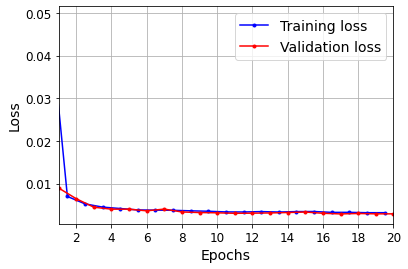

In [17]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

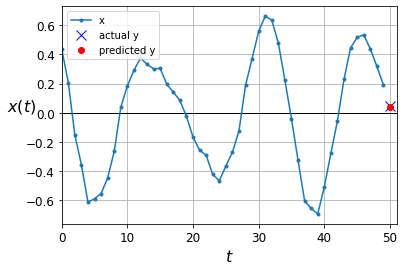

In [18]:
y_pred=deep_rnn.predict(X_test)
plot_series(X_test[0,:,0],y_test[0,0],y_pred[0,0])
plt.show()

In [19]:
deep_rnn_dense = keras.models.Sequential([
                                    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                                    keras.layers.SimpleRNN(20),
                                    keras.layers.Dense(1)
])
deep_rnn_dense.compile(loss="mse",optimizer="adam")
history=deep_rnn_dense.fit(X_train,y_train,epochs=20,
                     validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0096 - val_loss: 0.0038
Epoch 2/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 3/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 14s 65ms/step - loss: 0.002

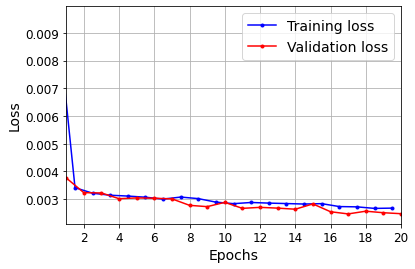

In [20]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

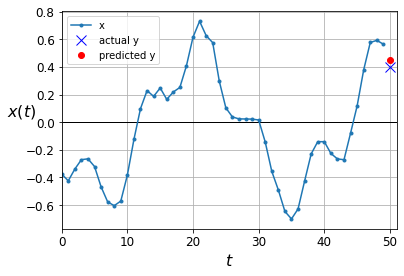

In [21]:
y_pred=deep_rnn_dense.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

In [22]:
np.random.seed(43)

series = generate_time_series(1,n_steps+10)
X_new, Y_new = series[:,:n_steps], series[:,n_steps:]
X = X_new
print("Original X shape: ",X.shape)

for step_ahead in range(10):
  print("{}".format(step_ahead),"iteration's X shape: ",X.shape, "Used data index : ","{} - {}".format(step_ahead,X.shape[1]-1))
  y_pred_one = deep_rnn_dense.predict(X[:,step_ahead:])[:,np.newaxis,:]
  X = np.concatenate([X,y_pred_one],axis=1)

Original X shape:  (1, 50, 1)
0 iteration's X shape:  (1, 50, 1) Used data index :  0 - 49
1 iteration's X shape:  (1, 51, 1) Used data index :  1 - 50
2 iteration's X shape:  (1, 52, 1) Used data index :  2 - 51
3 iteration's X shape:  (1, 53, 1) Used data index :  3 - 52
4 iteration's X shape:  (1, 54, 1) Used data index :  4 - 53
5 iteration's X shape:  (1, 55, 1) Used data index :  5 - 54
6 iteration's X shape:  (1, 56, 1) Used data index :  6 - 55
7 iteration's X shape:  (1, 57, 1) Used data index :  7 - 56
8 iteration's X shape:  (1, 58, 1) Used data index :  8 - 57
9 iteration's X shape:  (1, 59, 1) Used data index :  9 - 58


In [23]:
Y_pred = X[:,n_steps:]

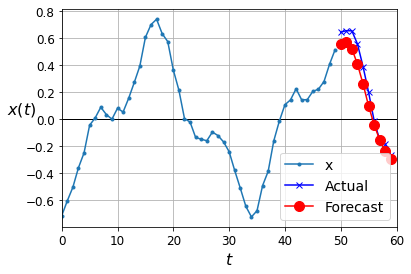

In [24]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 50
series = generate_time_series(10000,n_steps+10)

X_train, Y_train = series[:7000,:n_steps], series[:7000,-10:,0]
X_valid, Y_valid = series[7000:9000,:n_steps],series[7000:9000,-10:,0]
X_test, Y_test = series[9000:,:n_steps],series[9000:,-10:,0]

In [26]:
print(X_train.shape,Y_train.shape)
print(X_valid.shape,Y_valid.shape)
print(X_test.shape,Y_test.shape)

(7000, 50, 1) (7000, 10)
(2000, 50, 1) (2000, 10)
(1000, 50, 1) (1000, 10)


In [27]:
way2 = keras.models.Sequential([
                                keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                                    keras.layers.SimpleRNN(20),
                                    keras.layers.Dense(10)
])
way2.compile(loss="mse",optimizer="adam")
history=way2.fit(X_train,Y_train,epochs=20,
                     validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 66ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 15s 67ms/step - loss: 0.011

In [28]:
way2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [29]:
way2.evaluate(X_test,Y_test)

32/32 [==============================] - 0s 7ms/step - loss: 0.0081


0.008137843571603298

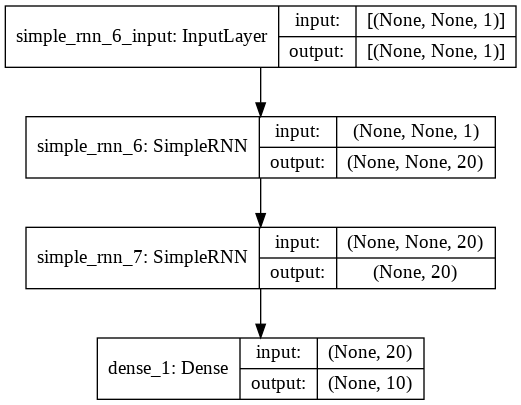

In [30]:
plot_model(way2,to_file="model_shapes.png",show_shapes=True)

In [31]:
np.random.seed(43)
series = generate_time_series(1,50+10)
X_new, y_new = series[:,:50,:], series[:,-10,:]
Y_pred = way2.predict(X_new)[...,np.newaxis]

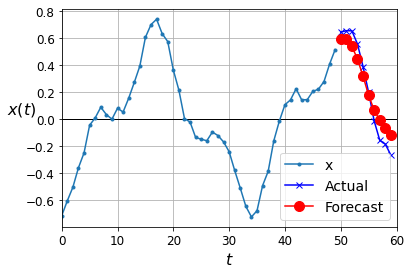

In [32]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

In [33]:
def last_time_step_mse(Y_true,Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:,-1],Y_pred[:,-1])

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

way3 = keras.models.Sequential([
                                    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                                    keras.layers.SimpleRNN(20,return_sequences=True),
                                    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [35]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000,n_steps+10)

X_train = series[:7000,:n_steps]
X_valid = series[7000:9000,:n_steps]
X_test = series[9000:,:n_steps]
Y = np.empty((10000,n_steps,10))

for step_ahead in range(1,10+1):
  Y[:,:,step_ahead-1] = series[:,step_ahead:step_ahead+n_steps,0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [36]:
way3.compile(loss="mse",optimizer="adam")
history=way3.fit(X_train,Y_train,epochs=20,
                     validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 66ms/step - loss: 0.0742 - val_loss: 0.0472
Epoch 2/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0441 - val_loss: 0.0411
Epoch 3/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0397 - val_loss: 0.0407
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0375 - val_loss: 0.0360
Epoch 5/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0357 - val_loss: 0.0348
Epoch 6/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0344 - val_loss: 0.0344
Epoch 7/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0337 - val_loss: 0.0327
Epoch 8/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0327 - val_loss: 0.0316
Epoch 9/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0319 - val_loss: 0.0313
Epoch 10/20
219/219 [==============================] - 14s 65ms/step - loss: 0.031

In [37]:
np.random.seed(43)

series = generate_time_series(1,50+10)
X_new, Y_new = series[:,:50,:],series[:,50:,:]
Y_pred = way3.predict(X_new)[:,-1][...,np.newaxis]

In [38]:
Y_pred = X[:,n_steps:]

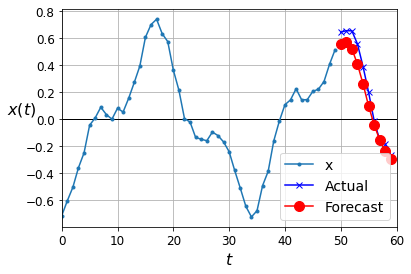

In [39]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

lstm = keras.models.Sequential([
                                keras.layers.LSTM(20,return_sequences=True,input_shape=[None,1]),
                                keras.layers.LSTM(20,return_sequences=True),
                                keras.layers.TimeDistributed(keras.layers.Dense(10))
])

lstm.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history = lstm.fit(X_train,Y_train,epochs=20,
                   validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 10ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [41]:
np.random.seed(43)

series = generate_time_series(1,50+10)
X_new, Y_new = series[:,:50,:], series[:,50:,:]
Y_pred = lstm.predict(X_new)[:,-1][...,np.newaxis]

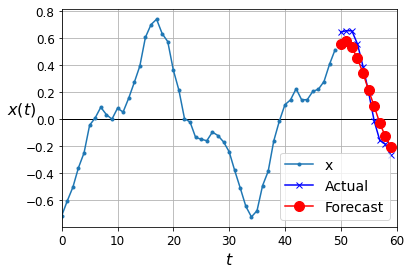

In [42]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

In [43]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = keras.utils.get_file("shakespeare.txt",shakespeare_url)
with open(filepath) as f:
  shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [44]:
print(shakespeare_text[1000:1500])

Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the commonalty.

Second Citizen:
Consider you what services he has done for his country?

First Citizen:
Very well; and could be content to give him good
report fort, but that he pays himself with being proud.

Second Citizen:
Nay, but speak not maliciously.

First Citizen:
I say unto you, what he hath done famously, he did
it to that end: though soft-conscienced men can be
content to 


In [45]:
len(shakespeare_text)

1115394

In [46]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [47]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [48]:
tokenizer.sequences_to_texts([[20,6,9,8,3]])

['f i r s t']

In [49]:
tokenizer.texts_to_sequences(["abcde"])

[[5, 22, 19, 13, 2]]

In [50]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text]))-1

In [51]:
max_id = len(tokenizer.word_index)
dataset_size = tokenizer.document_count

In [52]:
train_size = dataset_size*40 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [53]:
n_steps = 100
window_length = n_steps+1
dataset = dataset.window(window_length,shift=1,drop_remainder=True)

In [54]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [55]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:,:-1],windows[:,1:]))

In [56]:
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch,depth=max_id),Y_batch))

In [57]:
dataset = dataset.prefetch(1)

In [58]:
model = keras.models.Sequential([
                                 keras.layers.LSTM(64,return_sequences=True,input_shape=[None,max_id],
                                                   dropout=0.2,recurrent_dropout=0),
                                 keras.layers.LSTM(64,return_sequences=True,
                                                   dropout=0.2,recurrent_dropout=0),
                                 keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                                                 activation="softmax"))
                          
])
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")
history = model.fit(dataset,epochs=5)

Epoch 1/5
13940/13940 [==============================] - 165s 12ms/step - loss: 1.9953
Epoch 2/5
13940/13940 [==============================] - 163s 12ms/step - loss: 1.7760
Epoch 3/5
13940/13940 [==============================] - 165s 12ms/step - loss: 1.7327
Epoch 4/5
13940/13940 [==============================] - 164s 12ms/step - loss: 1.7133
Epoch 5/5
13940/13940 [==============================] - 166s 12ms/step - loss: 1.7014


In [59]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts))-1
  return tf.one_hot(X,max_id)

In [60]:
def next_char(text,temperature=1):
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0,-1:,:]
  rescaled_logits = tf.math.log(y_proba)/temperature
  char_id = tf.random.categorical(rescaled_logits,num_samples=1)+1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [61]:
def complete_text(text,n_chars=50,temperature=1):
  for _ in range(n_chars):
    text+=next_char(text,temperature)
  return text

In [62]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred+1)[0][-1]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'u'

In [63]:
print(complete_text("t",temperature=0.2))

the word of the words
that thou words the words in 


In [64]:
print(complete_text("w",temperature=0.2))

with the heads of the king,
that the words of the m


In [65]:
print(complete_text("w",temperature=0.8))

way?

sampson:
they are heart of the eemp'd hands e


In [66]:
import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
df = pd.read_csv("https://raw.githubusercontent.com/eepLearning/AIP2_RNN_LAB_Activity/main/Ulsan_temp_201905_202105.csv")

In [68]:
df.tail(10)

,Date,Temperature(M),Temperature(L),Temperature(H)
752,2021-05-23,23.7,16.3,30.5
753,2021-05-24,19.6,17.4,24.2
754,2021-05-25,19.0,13.9,24.3
755,2021-05-26,18.3,12.1,23.7
756,2021-05-27,19.1,14.9,24.4
757,2021-05-28,17.5,12.1,26.0
758,2021-05-29,19.3,12.1,25.9
759,2021-05-30,19.2,14.3,24.1
760,2021-05-31,19.0,15.2,25.1
761,2021-06-01,20.3,14.1,25.8


In [69]:
n_step = 5
temperature = df["Temperature(H)"].values
print(temperature.shape)

(762,)


In [70]:
temperature = temperature[:(temperature.shape[0]//(n_step+1))*(n_step+1)].reshape(-1,(n_step+1))

r = temperature.shape[0]

r

127

In [71]:
X_train,y_train = temperature[:int(r*0.8),:n_step,np.newaxis],temperature[:int(r*0.8),-1,np.newaxis]
X_valid, y_valid = temperature[int(r*0.8):int(r*0.9),:n_step,np.newaxis],temperature[int(r*0.8):int(r*0.9),-1,np.newaxis]
X_test, y_test = temperature[int(r*0.9):-1,:n_step,np.newaxis],temperature[int(r*0.9):-1,-1,np.newaxis]

print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)
print(X_test.shape,y_test.shape)

(101, 5, 1) (101, 1)
(13, 5, 1) (13, 1)
(12, 5, 1) (12, 1)


In [72]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
                                 keras.layers.LSTM(64,return_sequences=True, input_shape=[None,1]),
                                 keras.layers.LSTM(128,return_sequences=True),
                                 keras.layers.LSTM(256,return_sequences=True),
                                 keras.layers.LSTM(512, return_sequences=False),
                                keras.layers.Dense(1)

])

model.compile(loss="mse",optimizer="adam")
history = model.fit(X_train,y_train,epochs=500,
                    validation_data=(X_valid,y_valid))

Epoch 1/500
4/4 [==============================] - 18s 488ms/step - loss: 468.9529 - val_loss: 124.2506
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 324.9093 - val_loss: 82.7509
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 61.1964 - val_loss: 246.7825
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 89.2961 - val_loss: 132.3772
Epoch 5/500
4/4 [==============================] - 0s 12ms/step - loss: 62.1923 - val_loss: 69.7956
Epoch 6/500
4/4 [==============================] - 0s 12ms/step - loss: 66.4076 - val_loss: 86.7707
Epoch 7/500
4/4 [==============================] - 0s 14ms/step - loss: 59.9201 - val_loss: 114.0331
Epoch 8/500
4/4 [==============================] - 0s 14ms/step - loss: 58.2237 - val_loss: 119.6629
Epoch 9/500
4/4 [==============================] - 0s 13ms/step - loss: 53.6259 - val_loss: 104.9979
Epoch 10/500
4/4 [==============================] - 0s 13ms/step - loss: 55.4648 - val_los

In [73]:
model.evaluate(X_valid,y_valid)

1/1 [==============================] - 0s 15ms/step - loss: 31.3824


31.382389068603516

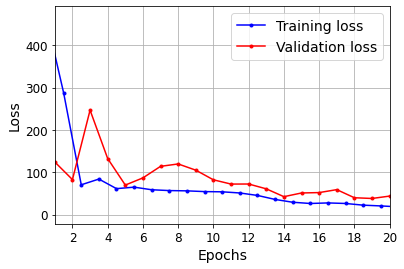

In [74]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])

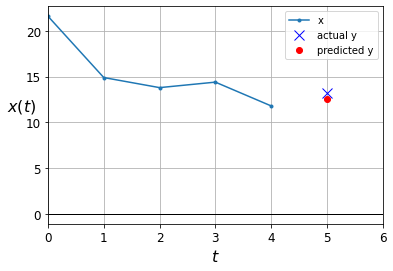

In [75]:
y_pred = model.predict(X_test)
plot_series(X_test[0,:,0],y_test[0,0],y_pred[0,0])
plt.show()

In [76]:
n_steps=5
real_temp = np.array([[26],[25.9],[24.1],[25.1],[25.8]]).reshape(1,n_steps,1)
model.predict(real_temp)

array([[25.292221]], dtype=float32)

In [77]:
for step_ahead in range(10):
  print("{}".format(step_ahead),"iteration's X shape: ",real_temp.shape, "Used data index : ","{} - {}".format(step_ahead,real_temp.shape[1]-1))
  y_pred_one = model.predict(real_temp[:,step_ahead:])[:,np.newaxis,:]
  print(y_pred_one.shape)
  real_temp = np.concatenate([real_temp,y_pred_one],axis=1)

0 iteration's X shape:  (1, 5, 1) Used data index :  0 - 4
(1, 1, 1)
1 iteration's X shape:  (1, 6, 1) Used data index :  1 - 5
(1, 1, 1)
2 iteration's X shape:  (1, 7, 1) Used data index :  2 - 6
(1, 1, 1)
3 iteration's X shape:  (1, 8, 1) Used data index :  3 - 7
(1, 1, 1)
4 iteration's X shape:  (1, 9, 1) Used data index :  4 - 8
(1, 1, 1)
5 iteration's X shape:  (1, 10, 1) Used data index :  5 - 9
(1, 1, 1)
6 iteration's X shape:  (1, 11, 1) Used data index :  6 - 10
(1, 1, 1)
7 iteration's X shape:  (1, 12, 1) Used data index :  7 - 11
(1, 1, 1)
8 iteration's X shape:  (1, 13, 1) Used data index :  8 - 12
(1, 1, 1)
9 iteration's X shape:  (1, 14, 1) Used data index :  9 - 13
(1, 1, 1)


In [78]:
print(real_temp)

[[[26.        ]
  [25.9       ]
  [24.1       ]
  [25.1       ]
  [25.8       ]
  [25.29222107]
  [25.64956665]
  [25.51302719]
  [24.53582382]
  [24.52146149]
  [25.35556602]
  [25.94186401]
  [26.1649456 ]
  [25.60970688]
  [24.27291679]]]


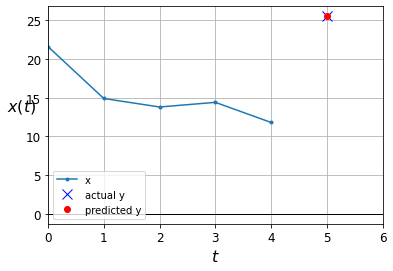

In [81]:
y_pred = model.predict(X_test)
plot_series(X_test[0,:,0],real_temp[0,7],real_temp[0,7])
plt.show()